### A coding scheme for Simon game sequences

#### **Author:** Sol Markman (smarkman@mit.edu)

Assumption: This scheme is hierarchical, so that different chunk types take priority over others. For example, repeats of a single color are chunked first, then repeats of multiple colors, then nested repeats, and then alternations are chunked with the remaining items, etc.
- RRRGRGRG is compressed to [R]^3 [GR]^2 G, size=6
- RRRGRG is compressed to [R]^3 [GRG], size=4

#### Types of chunks/compression and their sizes:

#### 1) Repeats
Size = (size of subsequence) + 1. This assumes that size does not increase with the number of repeats, and 
repeats are only beneficial for size>2.

a) Single color repeats
- RRRR is compressed to [R]^4, size=2

b) Multicolor repeats
- RGRGRG is compressed to [RG]^3, size=3
    
c) Nested repeats
- RRRGGGRRRGGG is compressed to [ [R]^3 [G]^3 ]^2, size=5

#### 2) Alternations
Not yet implemented

#### 3) Cycles
Not yet implemented

#### 4) Exposure compression (within a sequence)
Not yet implemented


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from common_methods import *

In [2]:
# Testing hyp1 code
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                    'BBBBBBBrrrBBBBBB', 'GGGGGGGG', 'ABCD', 'BGGGR', 'abbabbabba']
answers = [8, 7, 5, 8, 5, 6, 2, 4, 4, 10]
    
test_coding_scheme(simple_repeat_scheme, test_sequences, answers)

BBBRRRYYYGGG 8
(8, '[B]3[R]3[Y]3[G]3')
RRRZGZRRR 7
(7, '[R]3ZGZ[R]3')
BBBBGRY 5
(5, '[B]4GRY')
RRRYGYGYG 8
(8, '[R]3YGYGYG')
GBGBB 5
(5, 'GBG[B]2')
BBBBBBBrrrBBBBBB 6
(6, '[B]7[r]3[B]6')
GGGGGGGG 2
(2, '[G]8')
ABCD 4
(4, 'ABCD')
BGGGR 4
(4, 'B[G]3R')
abbabbabba 10
(10, 'a[b]2a[b]2a[b]2a')


In [3]:
# Testing hyp3 code
test_sequences = ['BBBRRRYYYGGG', 'RRRZGZRRR', 'BBBBGRY', 'RRRYGYGYG', 'GBGBB', 
                'BBBBBBBrrrBBBBBB', 'GRGRGRZDZDZDZTTTTTTTGGG', 'ababcdcdababcdcd',
                'abbabbabba', 'abcabcabc', 'abbccccabbccccabbcccc', 'bbbbaaaabbbbaaaa',
                'bbbaaabbbaaa', 'bbaabbaa', 'baba', 'bbaabbaab']
answers = [8, 7, 5, 5, 5, 6, 11, 7, 5, 4, 6, 5, 5, 5, 3, 6]

test_coding_scheme(complex_repeat_scheme, test_sequences, answers)

BBBRRRYYYGGG 8
(8, '[B]3[R]3[Y]3[G]3')
RRRZGZRRR 7
(7, '[R]3ZGZ[R]3')
BBBBGRY 5
(5, '[B]4GRY')
RRRYGYGYG 5
(5, '[R]3[YG]3')
GBGBB 5
(5, 'GBG[B]2')
BBBBBBBrrrBBBBBB 6
(6, '[B]7[r]3[B]6')
GRGRGRZDZDZDZTTTTTTTGGG 11
(11, '[GR]3[ZD]3Z[T]7[G]3')
ababcdcdababcdcd 7
(7, '[[ab]2[cd]2]2')
abbabbabba 5
(5, '[a[b]2]3a')
abcabcabc 4
(4, '[abc]3')
abbccccabbccccabbcccc 6
(6, '[a[b]2[c]4]3')
bbbbaaaabbbbaaaa 5
(5, '[[b]4[a]4]2')
bbbaaabbbaaa 5
(5, '[[b]3[a]3]2')
bbaabbaa 5
(5, '[[b]2[a]2]2')
baba 3
(3, '[ba]2')
bbaabbaab 6
(6, '[[b]2[a]2]2b')


In [75]:
# Methods for analysis

def get_code_lengths(scheme, seq):
    return scheme(seq)[0]

def get_chunkability_simple(scheme, seq):

    l = get_code_lengths(scheme, seq)
    chunkability = 1 - l/len(seq)
    return chunkability

def get_chunkability_percentile(scheme, seq, n_samples=1000):

    cl_samples = sample_compressed_lengths(scheme, len(seq), n_samples)
    cl_datapt = get_code_lengths(scheme, seq)
    cl_percentile = stats.percentileofscore(cl_samples, cl_datapt, kind='mean')
    chunkability = (50 - cl_percentile) # should positive if the compression length is less than the median

    return chunkability

def get_chunkabilities_from_logs(data_path, get_chunkability=get_chunkability_simple):
    session_data = parse_simons_game_logs(data_path)

    N_games = 0
    scores = []
    sequences = []

    for i, key in enumerate(session_data.keys()):
        N_games += len(session_data[key])
        for game in session_data[key].values():
            sequences.append(game['longest_sequence'])
            scores.append(len(game['longest_sequence']))

    print('Games: ', N_games)
    print('Scores: ', scores)
    print('Sequences: ', sequences)

    # Compute chunkabilities for each sequence
    simple_rep = []
    LZ = []
    complex_rep = []
    for seq in sequences:
        simple_rep.append(get_chunkability(simple_repeat_scheme, seq))
        LZ.append(get_chunkability(LZ_scheme, seq))
        complex_rep.append(get_chunkability(complex_repeat_scheme, seq))

    results = dict(scores=scores, sequences=sequences, simple_repeats=simple_rep, 
                   LZ_complexity=LZ, complex_repeats=complex_rep)
    return results

def get_measure_multiple_seqs(scheme, random_sequences, get_measure=get_code_lengths):
    
    measures = []
    for i in range(len(random_sequences)):
        seq = random_sequences[i]
        measures.append(get_measure(scheme, seq))
        
    return np.array(measures)

In [36]:
kind = 'mean'

print(stats.percentileofscore([1, 2, 3, 4, 5], 3, kind=kind))
print(stats.percentileofscore([1, 2, 3, 3, 3, 4, 5], 2, kind=kind))
print(stats.percentileofscore([1, 2, 3, 3, 3, 4, 5], 3, kind=kind))
print(stats.percentileofscore([1, 2, 3, 3, 3, 4, 5], 4, kind=kind))

50.0
21.42857142857143
50.0
78.57142857142857


Games:  50
Scores:  [10, 12, 9, 10, 9, 5, 6, 13, 5, 10, 10, 11, 11, 9, 7, 13, 7, 6, 10, 12, 5, 16, 11, 10, 7, 8, 8, 12, 7, 8, 5, 8, 13, 12, 7, 6, 9, 6, 8, 5, 11, 14, 7, 15, 9, 13, 9, 11, 5, 10]
Sequences:  ['BBYYRRRBGR', 'GBYBGGBYBBBB', 'YGGYRGBYB', 'YRRGGGRBGY', 'RGGBGRRRY', 'GYRBY', 'GRBBYR', 'RGRRYBYGYYBYB', 'YBRYG', 'RYBRRBRRRR', 'GYYRRRGYRG', 'GYYBBGBGGYR', 'YBBYGGYYBYB', 'RRGRGGRRY', 'BYYGYRB', 'BGBGYBBRYYYGB', 'GBYGRRY', 'YBBRGB', 'RGRBRRBRGG', 'BRRRYYBRBGGB', 'BYGBR', 'GRGRGGGBGGGYBBBR', 'GGGGYYRYBRR', 'RGRYYBGYYR', 'BYYGBRR', 'YGRYGBBG', 'YBGRYRBY', 'GBBRGGBYRYBR', 'YRRBBRG', 'GGYBYRRG', 'GBRGG', 'YGRGRBRB', 'RYRYRYRRBBYYB', 'RRYRRRYGYRGB', 'GYYBGBR', 'RGBGYB', 'RYRGBRGRB', 'BYRBYB', 'YRRYYGBB', 'BBRYR', 'YGYYBYBRBYG', 'GRYBGRYBRRBYGY', 'YRBBYBR', 'YGGGBBBRBRBBBYY', 'YRBYYBBBB', 'GGGRGRGGGYBRR', 'RRYRYGGYB', 'BRRRYRGBBGR', 'GRRBR', 'YGBGYGBRGY']
Hyp:   slope,   intercept,   r-value,   p-value,   std_err
Hyp1:  3.2826262626262634 -30.292161616161625 0.4101537667078676 0.0030940

Text(0.5, 0.98, 'For logs in ./Sol_logs/Random')

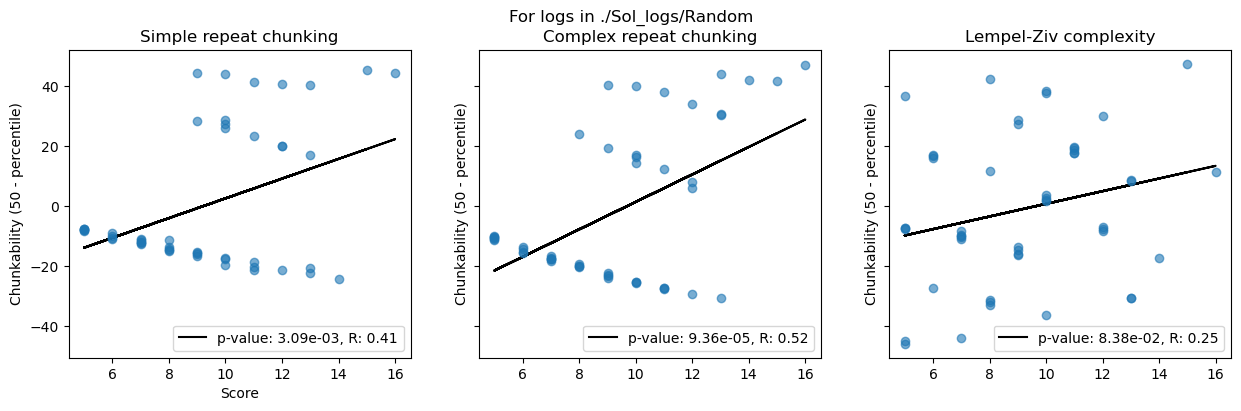

In [87]:
data_path = './Sol_logs/Random' #'./Jack_logs' # './Hokyung_logs' #'./Quilee_logs' #  
chunk_dict = get_chunkabilities_from_logs(data_path, get_chunkability=get_chunkability_percentile)
scores = chunk_dict['scores']
chunk1 = chunk_dict['simple_repeats']
chunk2 = chunk_dict['LZ_complexity']
chunk3 = chunk_dict['complex_repeats']

ylabel = 'Chunkability (50 - percentile)'

m1, b1, r1, p1, std_err1 = stats.linregress(scores, chunk1)
m2, b2, r2, p2, std_err2 = stats.linregress(scores, chunk2)
m3, b3, r3, p3, std_err3 = stats.linregress(scores, chunk3)

print('Hyp:   slope,   intercept,   r-value,   p-value,   std_err')
print('Hyp1: ', m1, b1, r1, p1, std_err1)
print('Hyp3: ', m3, b3, r3, p3, std_err3)

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=False, sharey=True)
ax[0].scatter(scores, chunk1, alpha=0.6)
ax[1].scatter(scores, chunk3, alpha=0.6)
ax[2].scatter(scores, chunk2, alpha=0.6)
ax[0].set(ylabel=ylabel, xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel=ylabel, title='Complex repeat chunking')
ax[2].set(ylabel=ylabel, title='Lempel-Ziv complexity')
ax[0].plot(np.array(scores), m1*np.array(scores) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(scores), m3*np.array(scores) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[2].plot(np.array(scores), m2*np.array(scores) + b2, color='k', zorder=0,
              label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
fig.suptitle(f'For logs in {data_path}')

Text(0.5, 0.98, 'Simulated random data')

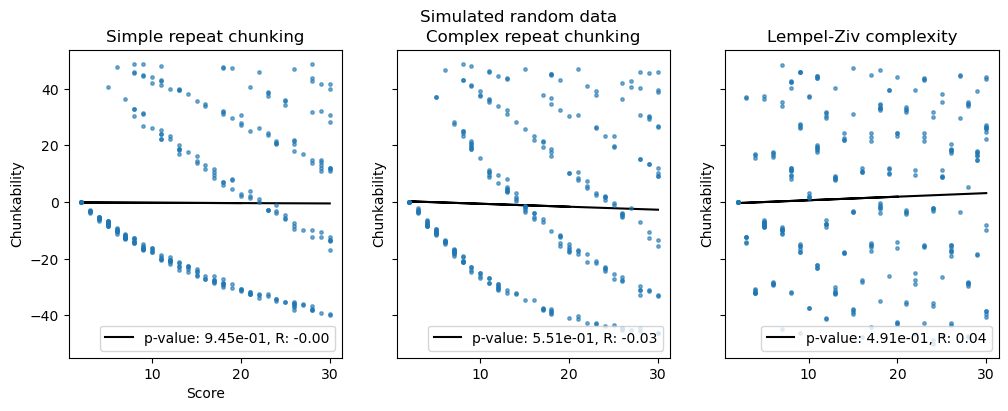

In [77]:
# Check that randomly simulated data yields no chunkability correlation

# Calculate measures for random sequences

np.random.seed(128)
random_seqs = sample_random_sequences(30, 300, min=2)
lengths = np.array([len(seq) for seq in random_seqs])

measure = get_chunkability_percentile
c1 = get_measure_multiple_seqs(simple_repeat_scheme, random_seqs, measure)
c2 = get_measure_multiple_seqs(LZ_scheme, random_seqs, measure)
c3 = get_measure_multiple_seqs(complex_repeat_scheme, random_seqs, measure)

m1, b1, r1, p1, std_err1 = stats.linregress(lengths, c1)
m2, b2, r2, p2, std_err2 = stats.linregress(lengths, c2)
m3, b3, r3, p3, std_err3 = stats.linregress(lengths, c3)

s = 6
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=True)
ax[0].scatter(lengths, c1, alpha=0.6, s=s)
ax[1].scatter(lengths, c3, alpha=0.6, s=s)
ax[2].scatter(lengths, c2, alpha=0.6, s=s)
ax[0].set(ylabel='Chunkability', xlabel='Score', title='Simple repeat chunking')
ax[1].set(ylabel='Chunkability', title='Complex repeat chunking')
ax[2].set(ylabel='Chunkability', title='Lempel-Ziv complexity')
ax[0].plot(np.array(lengths), m1*np.array(lengths) + b1, color='k', zorder=0, 
           label=f'p-value: {p1:.2e}, R: {r1:.2f}')
ax[1].plot(np.array(lengths), m3*np.array(lengths) + b3, color='k', zorder=0, 
           label=f'p-value: {p3:.2e}, R: {r3:.2f}')
ax[2].plot(np.array(lengths), m2*np.array(lengths) + b2, color='k', zorder=0,
              label=f'p-value: {p2:.2e}, R: {r2:.2f}')
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
fig.suptitle(f'Simulated random data')

[Text(0.5, 0, 'Sequence length'),
 Text(0, 0.5, 'Code length'),
 Text(0.5, 1.0, 'Lempel-Ziv complexity')]

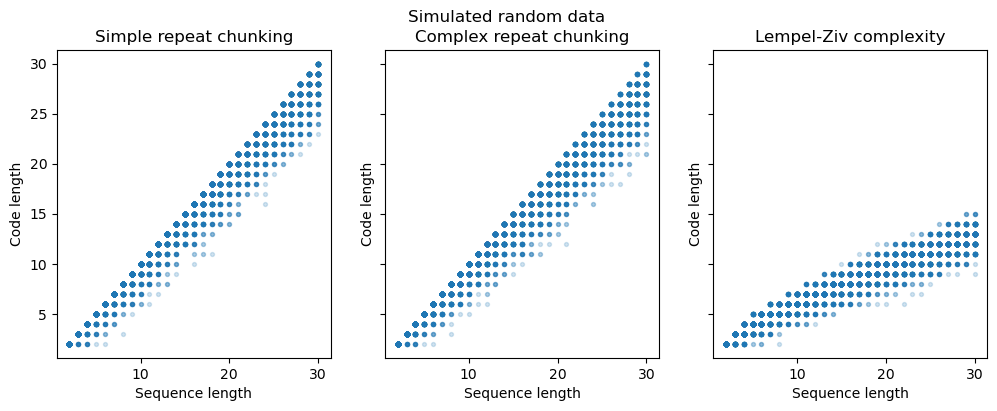

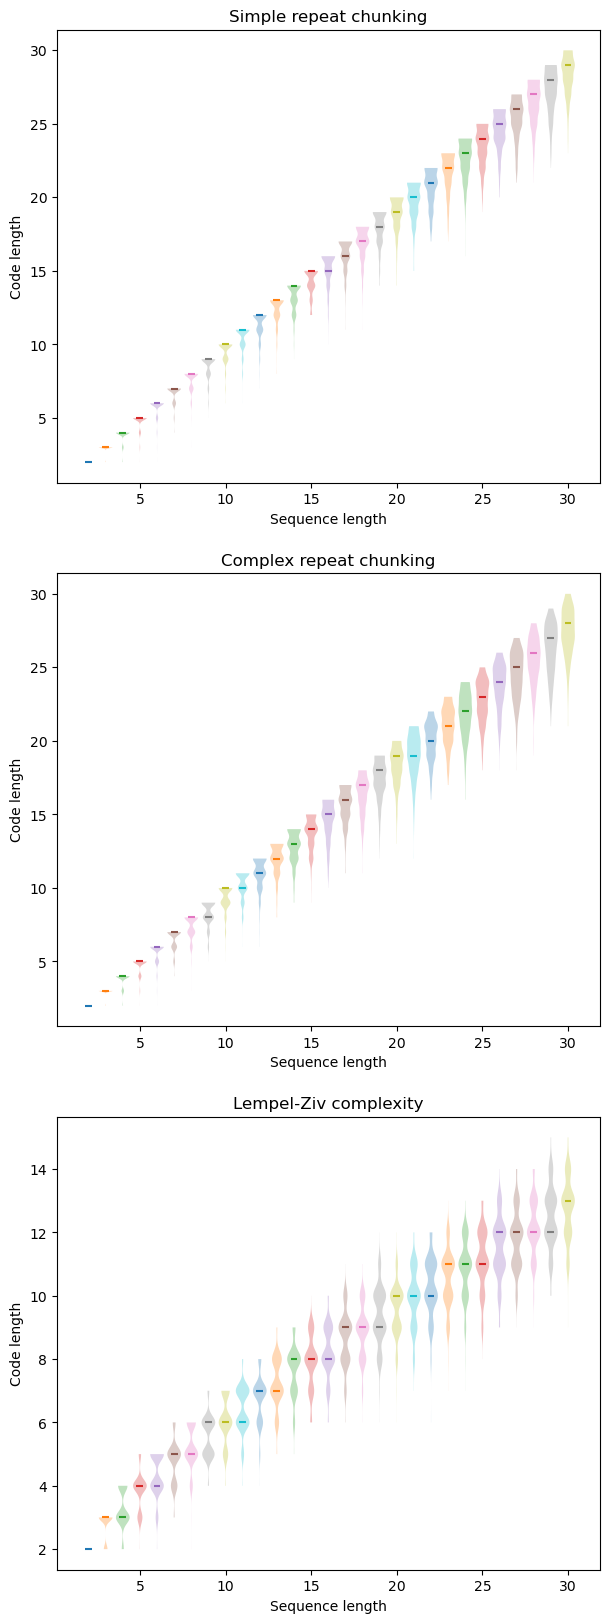

In [65]:
random_seqs = sample_random_sequences(30, 10000, min=2)
lengths = np.array([len(seq) for seq in random_seqs])

codelen1 = get_measure_multiple_seqs(simple_repeat_scheme, random_seqs, get_code_lengths)
codelen2 = get_measure_multiple_seqs(LZ_scheme, random_seqs, get_code_lengths)
codelen3 = get_measure_multiple_seqs(complex_repeat_scheme, random_seqs, get_code_lengths)

s = 8
a = 0.2
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].scatter(lengths, codelen1, alpha=a, s=s)
ax[1].scatter(lengths, codelen3, alpha=a, s=s)
ax[2].scatter(lengths, codelen2, alpha=a, s=s)
ax[0].set(xlabel='Sequence length', ylabel='Code length', title='Simple repeat chunking')
ax[1].set(xlabel='Sequence length', ylabel='Code length', title='Complex repeat chunking')
ax[2].set(xlabel='Sequence length', ylabel='Code length', title='Lempel-Ziv complexity')
fig.suptitle(f'Simulated random data')

unique_lens = np.unique(lengths)

fig, ax = plt.subplots(3, 1, figsize=(7, 20))
quantiles = []
for l in unique_lens:
    idx = np.where(lengths == l)
    ax[0].violinplot(codelen1[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[1].violinplot(codelen3[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    ax[2].violinplot(codelen2[idx], positions=[l], showextrema=False, 
                     showmedians=True, quantiles=quantiles, widths=0.8)
    

ax[0].set(xlabel='Sequence length', ylabel='Code length', title='Simple repeat chunking')
ax[1].set(xlabel='Sequence length', ylabel='Code length', title='Complex repeat chunking')
ax[2].set(xlabel='Sequence length', ylabel='Code length', title='Lempel-Ziv complexity')

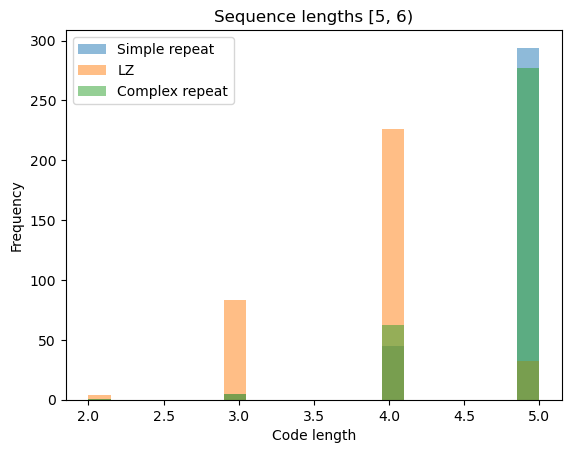

In [25]:
min_len = 5
max_len = 6
inds = np.where((np.array(lengths) >= min_len) & (np.array(lengths) < max_len))[0]

plt.hist(codelen1[inds], bins=20, alpha=0.5, label='Simple repeat')
plt.hist(codelen2[inds], bins=20, alpha=0.5, label='LZ')
plt.hist(codelen3[inds], bins=20, alpha=0.5, label='Complex repeat')
plt.xlabel('Code length')
plt.ylabel('Frequency')
plt.title(f'Sequence lengths [{min_len}, {max_len})')
plt.legend()

Text(0, 0.5, 'Chunkability')

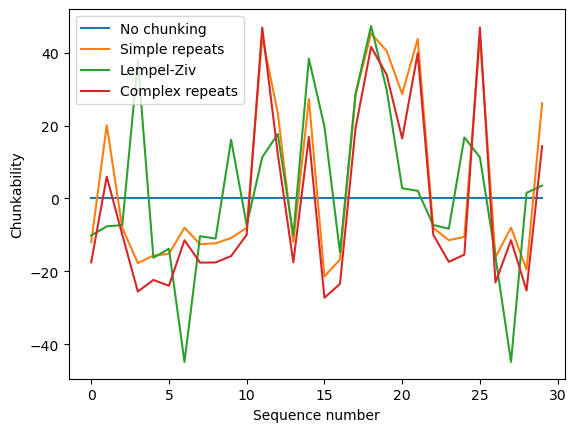

In [90]:
n = 30
np.random.seed(18)
inds = np.random.choice(np.arange(len(chunk1)), n)

plt.plot(np.arange(n), np.zeros(n), label='No chunking')
plt.plot(np.arange(n), np.array(chunk1)[inds], label='Simple repeats')
plt.plot(np.arange(n), np.array(chunk2)[inds], label='Lempel-Ziv')
plt.plot(np.arange(n), np.array(chunk3)[inds], label='Complex repeats')
plt.legend()
plt.xlabel('Sequence number')
plt.ylabel('Chunkability')

